# Test classification with noisy labels

### Common Imports

In [1]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.utils import shuffle
from sklearn.utils import resample
import torch

df_raw = pd.read_csv('data_banknote_authentication.txt', 
                     names=['variance', 'skewness', 'kurtosis', 'entropy', 'authentic'])
print(df_raw.authentic.value_counts())
print('Has null values:', df_raw.isnull().values.any())

0    762
1    610
Name: authentic, dtype: int64
Has null values: False


In [3]:
def make_balanced(tmp_df, TARGET_LABEL):
    df_majority = tmp_df[tmp_df[TARGET_LABEL] == 0]
    df_minority = tmp_df[tmp_df[TARGET_LABEL] == 1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                       replace=False,              # sample without replacement
                                       n_samples=len(df_minority), # to match minority class
                                       random_state=None)        # reproducible results
    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    df_downsampled = df_downsampled.sample(frac=1) #Shuffle the data
    df_downsampled = df_downsampled.reset_index() #Reset the index
    df_downsampled = df_downsampled.drop(columns=['index']) # Drop original index col
    return df_downsampled


def get_X_y(tmp_df, TARGET_LABEL):
    NON_LBL = [c for c in tmp_df.columns if c != 'authentic']
    X = tmp_df[NON_LBL].to_numpy()
    y = tmp_df['authentic'].to_numpy()
    return torch.from_numpy(X), torch.from_numpy(y)

In [4]:
df_balanced = make_balanced(df_raw, 'authentic')
df_balanced['authentic'].value_counts()

0    610
1    610
Name: authentic, dtype: int64

In [5]:
df_balanced.head(5)

,variance,skewness,kurtosis,entropy,authentic
0,0.6212,3.6771,-4.0771,-2.07110,1
1,-3.6012,-6.5389,10.5234,-0.48967,1
2,1.4806,7.6377,-2.7876,-1.03410,0
3,-1.5322,-5.0966,6.6779,0.17498,1
4,-2.0759,10.8223,2.6439,-4.83700,0


In [6]:
X,y_clean = get_X_y(df_balanced, 'authentic')
print(X.shape, y_clean.shape)

torch.Size([1220, 4]) torch.Size([1220])


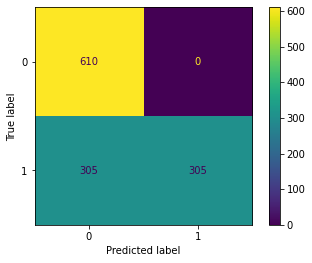

In [7]:
def flip(y_tmp, p01, p10):

    index_with_y_eq_1 = torch.arange(y_tmp.shape[0])[y_tmp == 1]
    index_with_y_eq_0 = torch.arange(y_tmp.shape[0])[y_tmp == 0]
    
    n_flips_10 = int(p10 * index_with_y_eq_1.shape[0])
    n_flips_01 = int(p01 * index_with_y_eq_0.shape[0])
    
    index_with_y_eq_1_permuted = index_with_y_eq_1[torch.randperm(index_with_y_eq_1.shape[0])]
    index_with_y_eq_0_permuted = index_with_y_eq_0[torch.randperm(index_with_y_eq_0.shape[0])]
       
    index_flips_10 = index_with_y_eq_1_permuted[:n_flips_10]   
    index_flips_01 = index_with_y_eq_0_permuted[:n_flips_01]   

    y_noisy = y_clean.clone()
    y_noisy[index_flips_10] = 0
    y_noisy[index_flips_01] = 1
    return y_noisy

y_noisy = flip(y_clean, p01=0.0, p10=0.5)
cm = sklearn.metrics.confusion_matrix(y_true=y_clean, y_pred=y_noisy)
disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
disp.plot()

In [349]:
%matplotlib inline
import matplotlib.pyplot as plt
from tissue_purifier.model_utils.classify_regress import *

def show_results(y_clean, y_noisy, y_pred, prob=None):
    cm_pred_wrt_clean = sklearn.metrics.confusion_matrix(y_true=y_clean, y_pred=y_pred)
    cm_pred_wrt_noisy = sklearn.metrics.confusion_matrix(y_true=y_noisy, y_pred=y_pred)
    cm_flip = sklearn.metrics.confusion_matrix(y_true=y_clean, y_pred=y_noisy)
    
    accuracy_wrt_clean = sklearn.metrics.accuracy_score(y_true=y_clean, y_pred=y_pred)
    accuracy_wrt_noisy = sklearn.metrics.accuracy_score(y_true=y_noisy, y_pred=y_pred)
    noise_rate = 1.0 - sklearn.metrics.accuracy_score(y_true=y_noisy, y_pred=y_clean)
    
    n_classes = cm_flip.shape[0]
    if prob is not None:
        fig, axes = plt.subplots(ncols=4, figsize=(16,4))
        _show_hist_internal(axes[3], y_clean, prob)
    else:
        fig, axes = plt.subplots(ncols=3, figsize=(12,4))
    
    # image 
    im0 = axes[0].imshow(cm_pred_wrt_clean)
    im1 = axes[1].imshow(cm_pred_wrt_noisy)
    im2 = axes[2].imshow(cm_flip)
    
    # colorbar
    # _ = plt.colorbar(im0, ax=axes[0])
    # _ = plt.colorbar(im1, ax=axes[1])
    # _ = plt.colorbar(im2, ax=axes[2])
    
    # write numbers in the centers
    for i in range(n_classes):
        for j in range(n_classes):
            _ = axes[0].text(j, i, cm_pred_wrt_clean[i, j], ha="center", va="center", color='red')
            _ = axes[1].text(j, i, cm_pred_wrt_noisy[i, j], ha="center", va="center", color='red')    
            _ = axes[2].text(j, i, cm_flip[i, j], ha="center", va="center", color='red')
                
    # titles
    _ = axes[0].set_title("Acc = {0}".format(accuracy_wrt_clean))
    _ = axes[1].set_title("Acc = {0}".format(accuracy_wrt_noisy))
    _ = axes[2].set_title("Flip Matrix. Rate = {0}".format(noise_rate))
    
    # axis labels
    axes[0].set_xlabel("predicted labels")
    axes[0].set_ylabel("clean labels")
    
    axes[1].set_xlabel("predicted labels")
    axes[1].set_ylabel("noisy labels")
    
    axes[2].set_xlabel("noisy labels")
    axes[2].set_ylabel("clean labels")
    
    # ticks
    ix = [i for i in range(n_classes)]
    axes[0].set_xticks(ticks=ix)
    axes[0].set_yticks(ticks=ix)
    axes[1].set_xticks(ticks=ix)
    axes[1].set_yticks(ticks=ix)
    axes[2].set_xticks(ticks=ix)
    axes[2].set_yticks(ticks=ix)
    
    plt.close(fig)
    return fig


def _show_hist_internal(ax, y_clean, prob):
    mask0 = (y_clean == 0)
    plt.hist(prob[mask0,1], label='class0', alpha=.5, range=(0,1), bins=25, edgecolor='black')
    plt.hist(prob[~mask0,1], label='class1', alpha=.5, range=(0,1), bins=25, edgecolor='black')
    ax.set_xlabel("prob for class 1")
    ax.set_ylabel("pdf")
    plt.legend()


def _show_auc_internal(ax, y_clean, prob):

    fpr0, tpr0, thr0 = sklearn.metrics.roc_curve(1-y_clean, prob[:,0])
    auc0 = sklearn.metrics.roc_auc_score(1-y_clean, prob[:, 0])
    fpr1, tpr1, thr1 = sklearn.metrics.roc_curve(y_clean, prob[:,1])
    auc1 = sklearn.metrics.roc_auc_score(y_clean, prob[:, 1])


    ax.plot(fpr0, tpr0)
    ax.plot(fpr1, tpr1)
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
        
    # ax.set_title("AUC = {0}".format(auc_list))
    ax.set_title("AUC = {:.2f},  {:.2f}".format(auc0, auc1))
 
    
def show_AUC(y_clean, prob):
    fig, axes = plt.subplots(ncols=1, figsize=(4,4))
    _show_auc_internal(axes, y_clean, prob)
    plt.close(fig)
    return fig  

def show_hist(y_clean, prob):
    fig, axes = plt.subplots(ncols=1, figsize=(4,4))
    _show_hist_internal(axes, y_clean, prob)
    plt.close(fig)
    return fig  

# Scikit Learn classifiers

### KNN with K=1

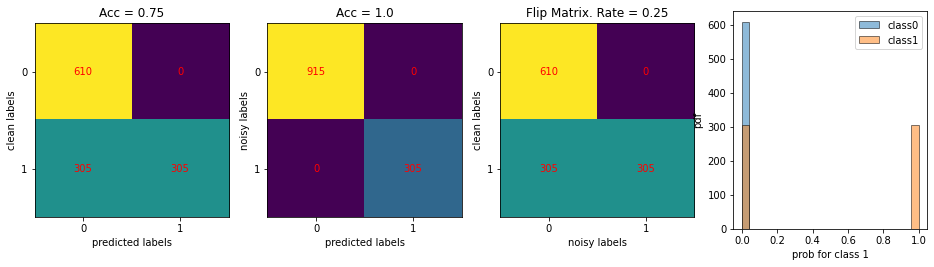

In [351]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf1.fit(X,y_noisy)
y_pred = clf1.predict(X)
prob = clf1.predict_proba(X)

# print("clean", numpy.bincount(y_clean))
# print("noisy", numpy.bincount(y_noisy))
# print("pred", numpy.bincount(y_pred))
show_results(y_clean, y_noisy, y_pred, prob)

### KNN with K=20

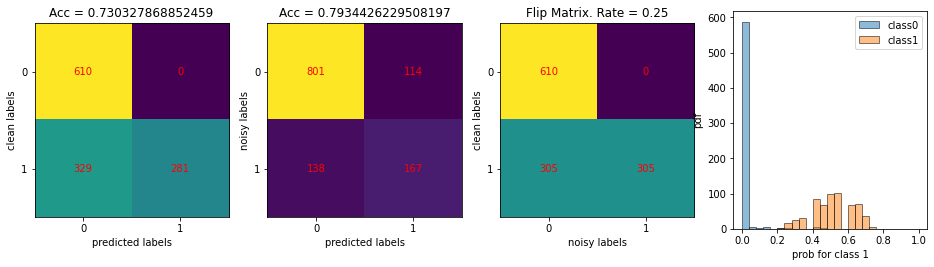

In [353]:
clf2 = KNeighborsClassifier(n_neighbors=20)
clf2.fit(X,y_noisy)
y_pred = clf2.predict(X)
prob = clf2.predict_proba(X)
# print("clean", numpy.bincount(y_clean))
# print("noisy", numpy.bincount(y_noisy))
# print("pred", numpy.bincount(y_pred))
show_results(y_clean, y_noisy, y_pred, prob)

### MLP classifier

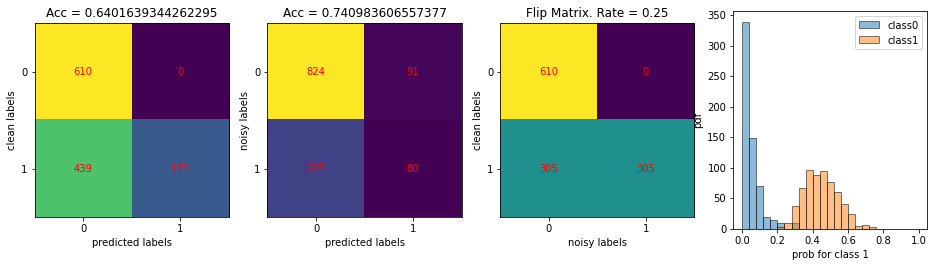

In [354]:
from sklearn.neural_network import MLPClassifier

clf3 = MLPClassifier(hidden_layer_sizes=[], max_iter=20000)
clf3.fit(X,y_noisy)
y_pred = clf3.predict(X)
prob = clf3.predict_proba(X)
# print("clean", numpy.bincount(y_clean))
# print("noisy", numpy.bincount(y_noisy))
# print("pred", numpy.bincount(y_pred))
show_results(y_clean, y_noisy, y_pred, prob)

# My Classifiers

### Simple MLP trained with the clean labels

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | criterium | CrossEntropyLoss | 0     
1 | net       | Sequential       | 10    
-----------------------------------------------
10        Trainable params
0         Non-trainable params
10        Total params
0.000     Total estimated model params size (MB)
/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

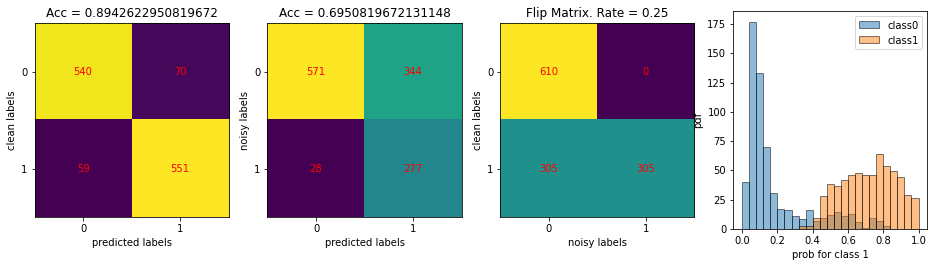

In [355]:
clf4 = PlClassifier(noisy_labels=False, max_iter=200)
clf4.fit(X,y_clean)
y_pred = clf4.predict(X)
prob = clf4.predict_proba(X)
show_results(y_clean, y_noisy, y_pred, prob)

### Simple MLP trained with the noisy labels

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | criterium | CrossEntropyLoss | 0     
1 | net       | Sequential       | 10    
-----------------------------------------------
10        Trainable params
0         Non-trainable params
10        Total params
0.000     Total estimated model params size (MB)
/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

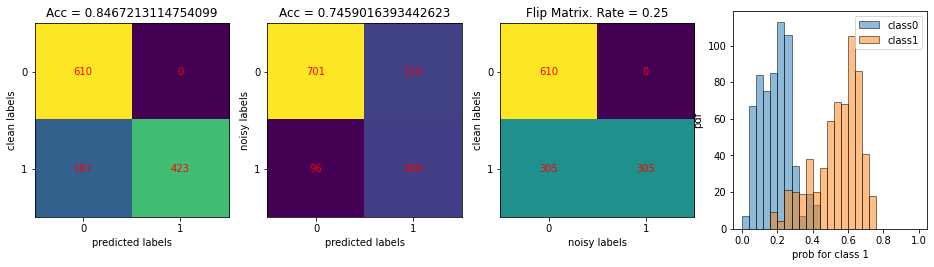

In [356]:
clf5 = PlClassifier(noisy_labels=False, max_iter=200)
clf5.fit(X,y_noisy)
y_pred = clf5.predict(X)
prob = clf5.predict_proba(X)
show_results(y_clean, y_noisy, y_pred, prob)

# Noise Labels

In [357]:
clf5 = PlClassifier(noisy_labels=True, max_iter=2000, solver='sgd', bootstrap_epoch_start=100,
                    warm_up_epochs=100, warm_down_epochs=1000,
                   )
vars(clf5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


{'noisy_labels': True,
 'bootstrap_epoch_start': 100,
 'lambda_reg': 1.0,
 'hard_bootstrapping': False,
 'classes_': None,
 'output_activation': Identity(),
 'hidden_dims': [],
 'hidden_activation': ReLU(inplace=True),
 'solver': 'sgd',
 'batch_size': 256,
 'max_iter': 2000,
 'betas': (0.9, 0.999),
 'alpha': 0.99,
 'momentum': 0.9,
 'warm_up_epochs': 100,
 'warm_down_epochs': 1000,
 'min_learning_rate': 0.0001,
 'max_learning_rate': 0.001,
 'min_weight_decay': 0.0,
 'max_weight_decay': 0.0001,
 '_mlp': None,
 '_is_fit': False,
 '_trainer': <pytorch_lightning.trainer.trainer.Trainer at 0x7fc5d9c8ec40>}


  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 10    
------------------------------------
10        Trainable params
0         Non-trainable params
10        Total params
0.000     Total estimated model params size (MB)
/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

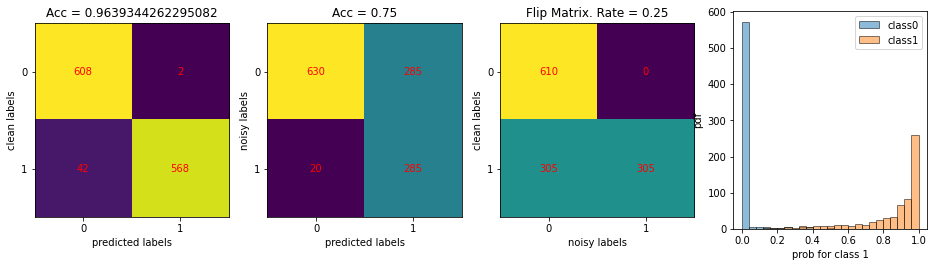

In [358]:
clf5.fit(X,y_noisy)
y_pred = clf5.predict(X)
prob = clf5.predict_proba(X)
show_results(y_clean, y_noisy, y_pred, prob)

In [361]:
trainer = Trainer()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [265]:
vars(clf5.mlp.bmm_model)

{'alphas_init': [1, 2],
 'betas_init': [2, 1],
 'weights_init': [0.5, 0.5],
 'alphas': array([0.10868713, 1.183332  ]),
 'betas': array([1.52895794, 0.75937479]),
 'weight': array([0.86952325, 0.13047675]),
 'max_iters': 50,
 'lookup': array([1.43480157e-13, 8.08719355e-03, 1.70137524e-02, 2.62658904e-02,
        3.57206347e-02, 4.53165012e-02, 5.50158515e-02, 6.47930399e-02,
        7.46293838e-02, 8.45106394e-02, 9.44255855e-02, 1.04365164e-01,
        1.14321924e-01, 1.24289647e-01, 1.34263087e-01, 1.44237774e-01,
        1.54209875e-01, 1.64176085e-01, 1.74133547e-01, 1.84079778e-01,
        1.94012624e-01, 2.03930213e-01, 2.13830921e-01, 2.23713340e-01,
        2.33576260e-01, 2.43418642e-01, 2.53239604e-01, 2.63038406e-01,
        2.72814435e-01, 2.82567199e-01, 2.92296312e-01, 3.02001488e-01,
        3.11682535e-01, 3.21339347e-01, 3.30971900e-01, 3.40580247e-01,
        3.50164512e-01, 3.59724890e-01, 3.69261642e-01, 3.78775092e-01,
        3.88265624e-01, 3.97733686e-01, 4.071

In [266]:
bmm_model = clf5.mlp.bmm_model

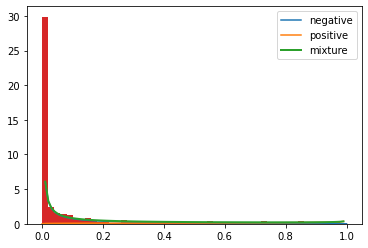

In [267]:
bmm_model.plot()

(array([804.,  65.,  36.,  36.,  26.,  28.,  22.,  25.,  26.,  30.]),
 array([1.0000e-04, 1.0008e-01, 2.0006e-01, 3.0004e-01, 4.0002e-01,
        5.0000e-01, 5.9998e-01, 6.9996e-01, 7.9994e-01, 8.9992e-01,
        9.9990e-01], dtype=float32),
 <a list of 10 Patch objects>)

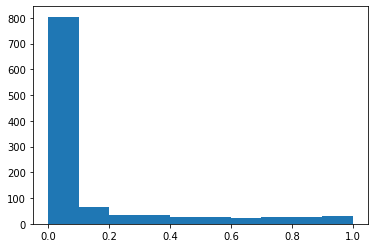

In [268]:
#bmm_model.empirical_loss.max()
plt.hist(bmm_model.empirical_loss)

In [269]:
bmm_model.weight

array([0.86952325, 0.13047675])

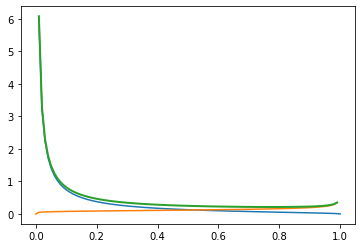

In [270]:
x = np.linspace(0, 1, 100)
plt.plot(x, bmm_model.weighted_likelihood(x, 0), label='negative')
plt.plot(x, bmm_model.weighted_likelihood(x, 1), label='positive')
plt.plot(x, bmm_model.probability(x), lw=2, label='mixture')
#plt.legend()
#_ = plt.hist(bmm_model.empirical_loss, bins=50, density=True)

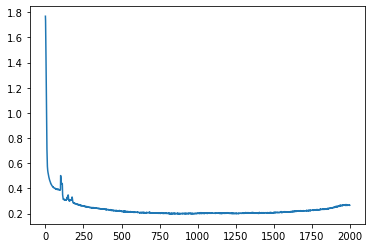

In [271]:
plt.plot(clf5.mlp.loss_curve_)
#plt.ylim(0.35, 0.5)
#plt.xlim(0.0, 170)

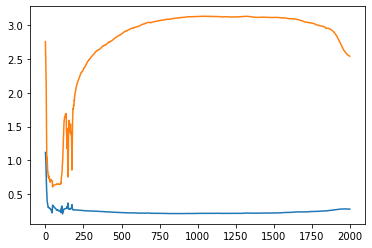

In [272]:
plt.plot(clf5.mlp.bmm_fitted_mean_0)
plt.plot(clf5.mlp.bmm_fitted_mean_1)
#plt.xlim(0, 300)